In [16]:
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import random
import matplotlib.pyplot as plt

window_size = 12

In [10]:
df = pd.read_pickle('test_dataset.pkl')
data = df.values.astype(float)
df.head()

1,Date,Weekly U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon),Weekly U.S. Imports of Crude Oil and Petroleum Products (Thousand Barrels per Day),Weekly U.S. Imports of Crude Oil (Thousand Barrels per Day),Weekly U.S. Commercial Crude Oil Imports Excluding SPR (Thousand Barrels per Day),Weekly U.S. Crude Oil Imports by SPR (Thousand Barrels per Day),Weekly U.S. Imports of Total Petroleum Products (Thousand Barrels per Day),Weekly U.S. Imports of Total Gasoline (Thousand Barrels per Day),Weekly U.S. Imports of Gasoline Blending Components (Thousand Barrels per Day),Weekly U.S. Imports of Kerosene-Type Jet Fuel (Thousand Barrels per Day),Weekly U.S. Imports of Distillate Fuel Oil (Thousand Barrels per Day),Weekly U.S. Imports of Residual Fuel Oil (Thousand Barrels per Day),Weekly U.S. Exports of Crude Oil and Petroleum Products (Thousand Barrels per Day),Weekly U.S. Exports of Crude Oil (Thousand Barrels per Day),Weekly U.S. Net Imports of Crude Oil and Petroleum Products (Thousand Barrels per Day)
1080,1386892800,3.321,9739,7732,7732,0,2007,599,544,63,226,233,3443,57,6296
1081,1387497600,3.351,9145,7535,7535,0,1610,486,428,46,175,295,3641,58,5504
1082,1388102400,3.409,8818,7495,7495,0,1323,247,238,31,140,183,3641,58,5177
1083,1388707200,3.411,9383,7961,7961,0,1422,379,369,61,114,215,3641,58,5742
1084,1389312000,3.406,8267,6889,6889,0,1378,405,397,48,208,102,3641,58,4626


In [11]:
price_pct = [0]
for i in range(1, data.shape[0]):
    price_pct.append((data[i, 1] - data[i-1, 1])/data[i-1, 1])
price_pct = np.array(price_pct, dtype=float)
prices = data[:, 1].copy()
data[:, 1] = price_pct

normalized_features = MinMaxScaler().fit_transform(data[:, 2:])
train_X = np.hstack((normalized_features, np.array(price_pct).reshape(-1, 1)))
train_X = np.array([train_X[i-window_size:i, :] for i in range(window_size, len(data))], dtype=np.float32)
train_y = price_pct[window_size:]

train_X.shape, train_y.shape

((450, 12, 14), (450,))

In [12]:
def build_model(shape, optimizer):
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    random.seed(12345)
    np.random.seed(12345)
    tf.random.set_seed(12345)
    
    model = tf.keras.Sequential()
    model.add(LSTM(units=32, return_sequences=True,
                    input_shape=shape, dropout=0.2))
    model.add(LSTM(units=32, return_sequences=True,
                    dropout=0.2))
    model.add(LSTM(units=32, dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def model_results(train_X, train_y, test_X):
    model = build_model(train_X.shape[1:], 'adam')
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10) 
    history = model.fit(train_X, train_y, epochs=200, batch_size=32, verbose=0, callbacks=[es])
    return history.history['loss'][-1], model.predict(test_X)

In [26]:
history, preds = model_results(train_X, train_y, train_X)

preds = preds.reshape(-1)

print(f'R2: {r2_score(train_y, preds)}')
print(f'RMSE: {mean_squared_error(train_y, preds, squared=False)}')

Epoch 32: early stopping
R2: 0.07173302169392026
RMSE: 0.018776345205789056


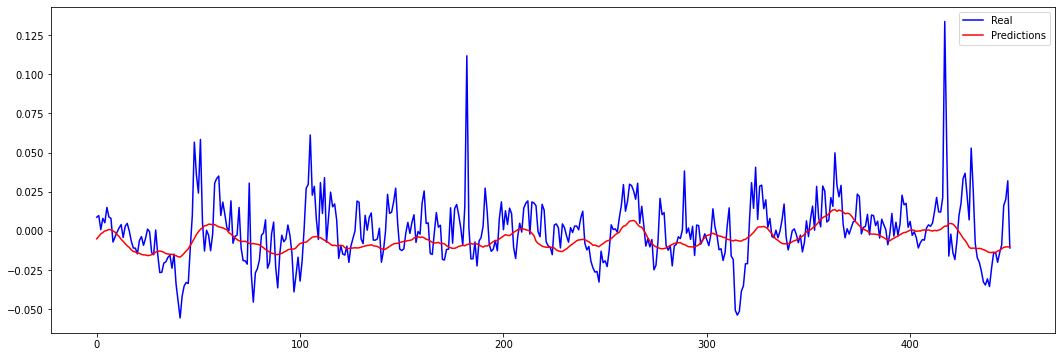

In [33]:
plt.figure(figsize=(18, 6))
plt.plot(range(len(data)-window_size), train_y, color='blue', label='Real')
plt.plot(range(len(data)-window_size), preds, color='red', label='Predictions')
plt.legend()
plt.show()

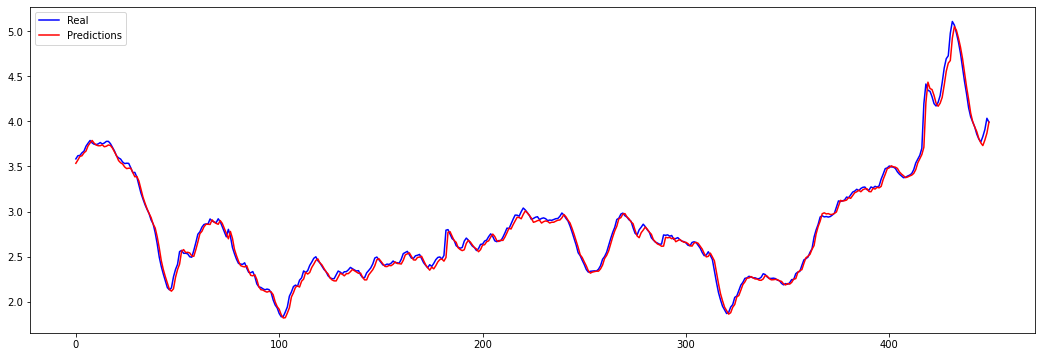

In [32]:
predicted_price = (preds+1) * prices[window_size-1:-1]

plt.figure(figsize=(18, 6))
plt.plot(range(len(data)-window_size), prices[window_size:], color='blue', label='Real')
plt.plot(range(len(data)-window_size), predicted_price, color='red', label='Predictions')
plt.legend()
plt.show()